In [1]:
library(dplyr)
library(zoo)
library(tseries)


Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union



Attachement du package : ‘zoo’


Les objets suivants sont masqués depuis ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



# Auteurs

* Arnaud PELISSIER
* Émilien HUILLET

# Chargement et préparation

Les données qui seront analysées sont la valeur quotidienne de l'indice CAC40, depuis l'année 1995 jusqu'à aujourd'hui. Elle proviennent du site MarketWatch.

In [2]:
# Source: https://www.marketwatch.com/investing/index/PX1?countrycode=FR (MarketWatch)
raw_data <- read.csv("data/CAC40_daily.csv")

# ne garder que les variables pertinentes pour notre étude
df <- data.frame(raw_data)[c("Date", "High", "Low", "Open")]

# Convertir les dates
df$Date <- as.Date(df$Date)

In [3]:
summary(df$Open)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1438    3051    4213    4213    5325    8242     147 

Ces données comportent plusieurs valeurs nulles. Il n'est pas possible en l'état de travailler avec des valeurs nulles, il faut donc les supprimer. Une solution consisterait à supprimer les lignes incomplètes mais cela créerait des trous. La solution choisie ici consiste à remplacer les valeurs manquantes par la moyenne des prix des jours précédent et suivant. En effet cela permettra de conserver la tendance tout en ayant des données relativement lisses dans le temps. 

In [4]:
# Si une donnée manque, utiliser la moyenne des jours précédent et suivants
df$Open <- na.approx(df$Open)
df$High <- na.approx(df$High)
df$Low <- na.approx(df$Low)

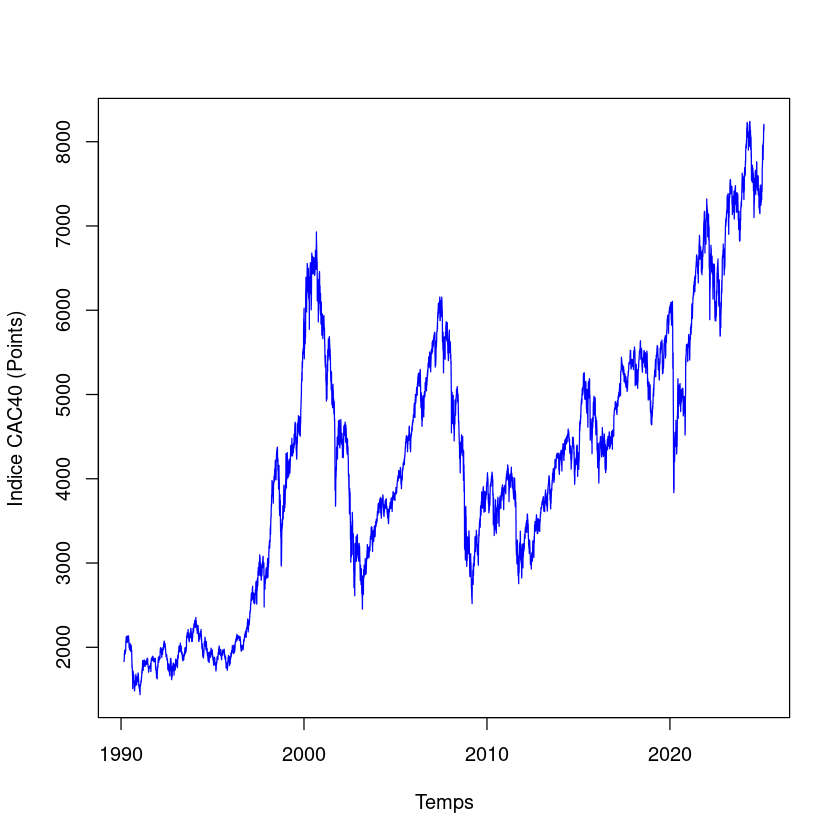

In [5]:
plot(df$Date, df$Open, type="l", col="blue", xlab="Temps", ylab="Indice CAC40 (Points)")

Les données sont très complexes et on sait avec le recul que différentes périodes correspondent à différentes logiques / régimes pour cette courbe. Par exemple, la crise économique de 2008 ou bien celle de 2020 ne peuvent pas êtres prédites à l'avance uniquement via les données précedentes, et changent complètement le modèle de la courbe.
Par conséquent, nous allons restreindre notre étude aux année 1995-1996.

In [6]:
# On choisit un sous-ensemble des données
train_begin <- as.Date("2000-01-01")
train_end <- as.Date("2002-01-01")
test_end <- as.Date("2002-06-01")

train_df <- df[df$Date >= train_begin & df$Date < train_end,]
test_df <- df[df$Date >= train_end & df$Date < test_end,]


# Éxploration

Utilisation d'une moyenne mobile pour obtenir une courbe moins bruitée

In [7]:
moving_average <- stats::filter(train_df$Open, filter=array(1/32, dim=32), circular=FALSE, sides=2, method="convolution")

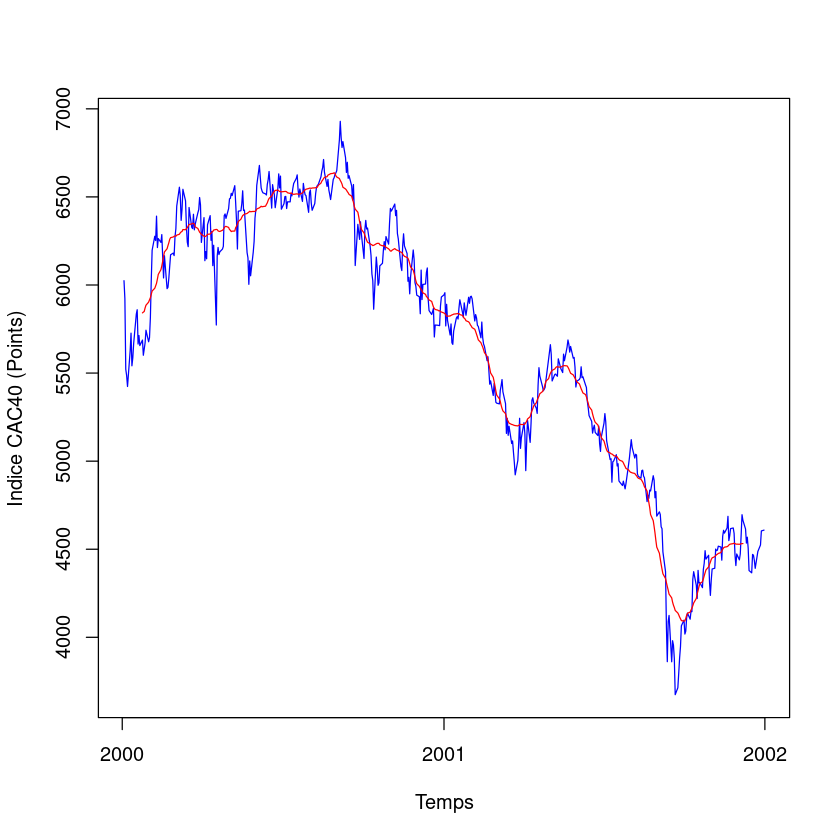

In [8]:
plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Temps", ylab="Indice CAC40 (Points)")
lines(train_df$Date, moving_average, type="l", col="red")

# Décomposition

## Saisonnalié

La courbe de l'indice CAC40 est soumise aux lois du marché, par conséquent toute saisonnalité est une opportunité pour un tiers d'obtenir un bénéfice, ce qui diminue la composante saisonniaire. On ne s'attend pas à observer de saisonnalité ce qui se vérifie visuellement sur la courbe.

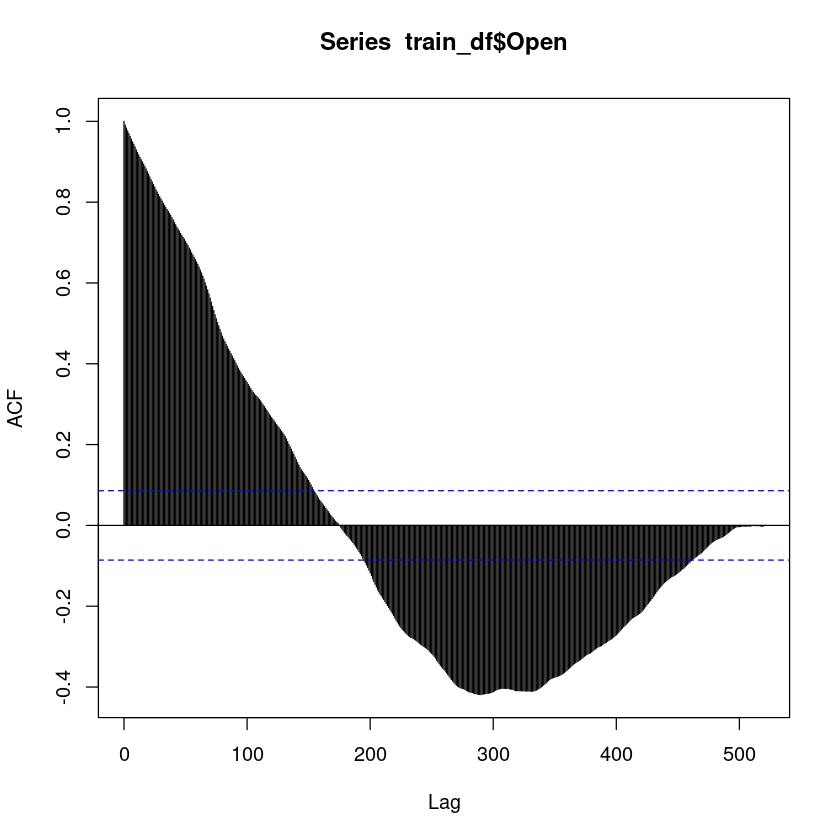

In [9]:
acf(train_df$Open, lag.max=length(train_df$Open))

Observations: Les valeurs de l'autocorrelation sont statistiquement significatives mais ses pics n'apparaissent pas à intervalles réguliers, et ne sont pas assez nombreux pour conclure sur l'enventuelle fréquence de ces saisons.

## Tendance


### Modèle linéaire

### 
Une première approche pour calculer la tendance de l'indice est d'utiliser un simple modèle linéaire pour prédire les valeurs connues.


Call:
lm(formula = train_df$Open ~ train_df$Date)

Residuals:
     Min       1Q   Median       3Q      Max 
-1336.56  -192.99    49.28   291.85   919.21 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   40763.9272   961.3761   42.40   <2e-16 ***
train_df$Date    -3.1017     0.0849  -36.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 408 on 519 degrees of freedom
Multiple R-squared:   0.72,	Adjusted R-squared:  0.7195 
F-statistic:  1335 on 1 and 519 DF,  p-value: < 2.2e-16


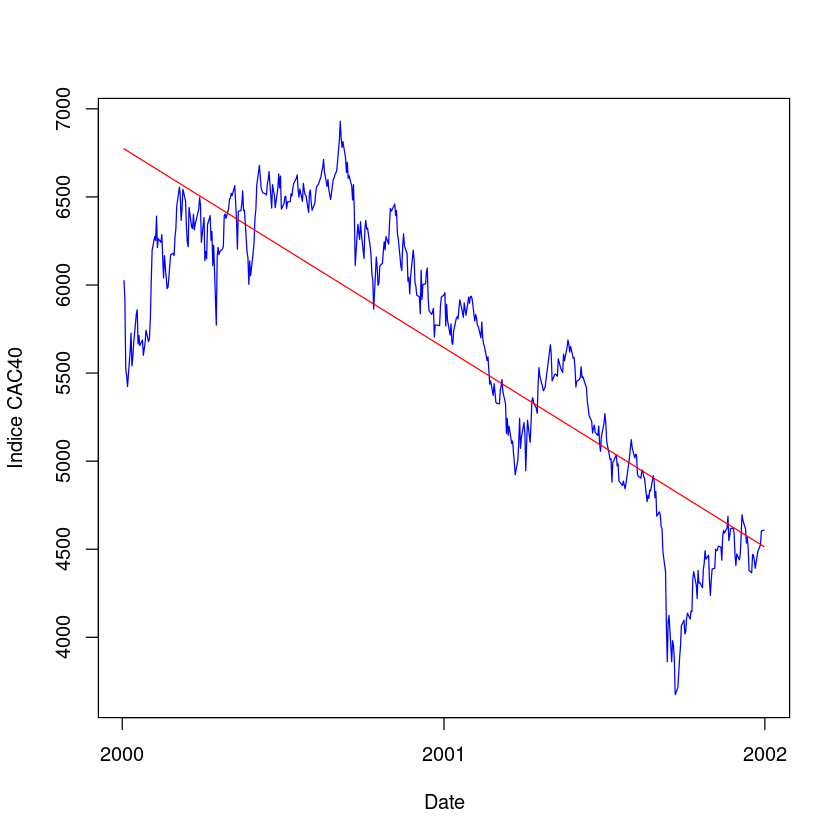

In [10]:
linear_model <- lm(train_df$Open ~ train_df$Date)
plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Date", ylab="Indice CAC40")

model_prediction <- data.frame(
  Date = seq(as.Date("1995-01-01"), by = "day", length.out = length(train_df$Open))
)

model_prediction$predicted <- predict(linear_model, newdata = model_prediction)
lines(train_df$Date, model_prediction$predicted, col="red")
summary(linear_model)

Même si l'approximation linéaire permet de voir une tendance à la baisse de l'indice du CAC40, on remarque qu'elle est assez éloignée de la courbe originale et qu'elle ne donne donc pas une bonne approximation de notre courbe réelle.


	Augmented Dickey-Fuller Test

data:  linear_model$residuals
Dickey-Fuller = -3.3346, Lag order = 8, p-value = 0.06472
alternative hypothesis: stationary


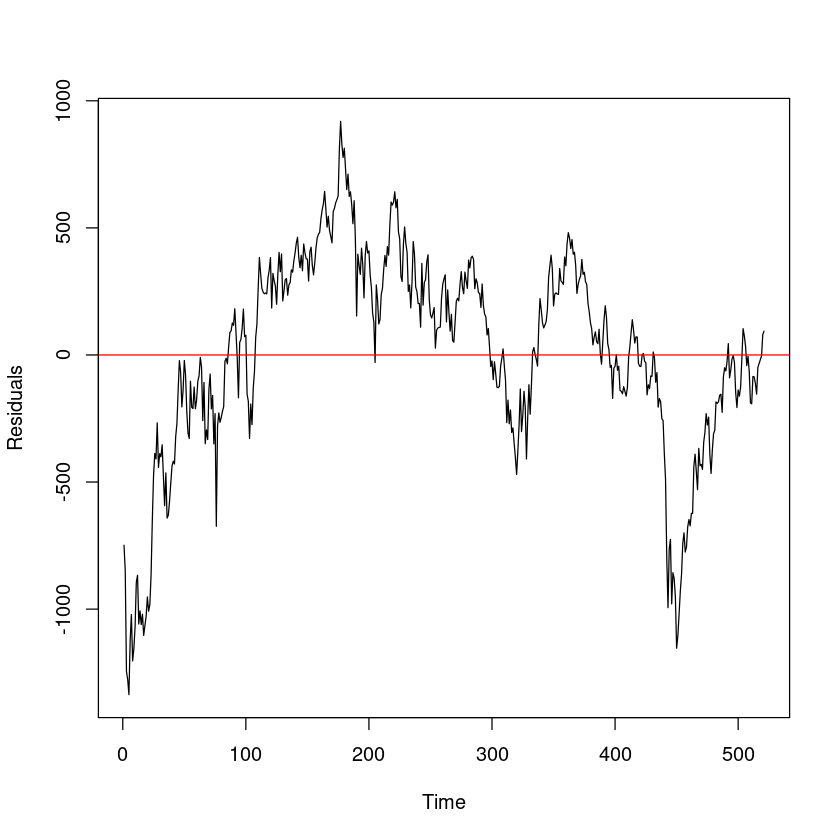

In [11]:
plot(linear_model$residuals, type="l", xlab="Time", ylab="Residuals")
abline(0, 0, col="red")
adf.test(linear_model$residuals)

On remarque une valeur absolue maximale supérieure à -1000, ainsi qu'une répartition inégale autour de zéro des valeurs des résidus, ce qui confirme la première impression que l'approximation linéaire ne permet pas de décrire la tendance de l'indice CAC40
Le test de stationnarité semble confirmer cette intuition, en effet sa p-value est de 6% > 5%, on ne peut donc pas rejeter l'hypothèse selon laquelle les résiduts sont non stationnaires.

### Modèle quadratique

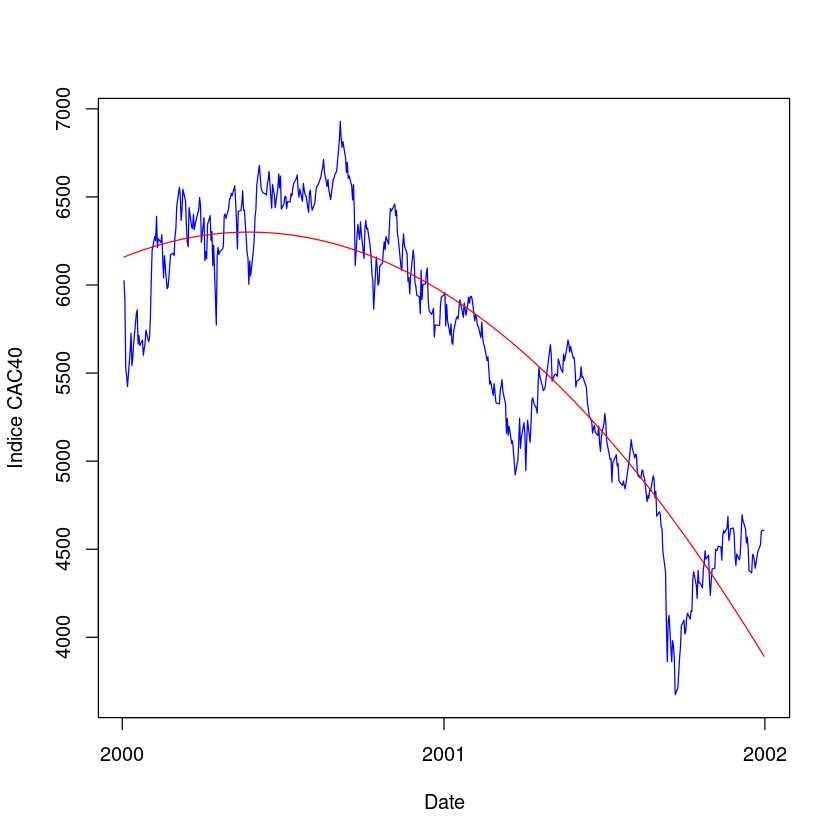

In [12]:
t <- as.numeric(train_df$Date)
tt <- t*t

quadratic_model <- lm(train_df$Open ~ t + tt)
plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Date", ylab="Indice CAC40")

pred <- data.frame(
  Date = seq(as.Date("1995-01-01"), by = "day", length.out = length(train_df$Open))
)

pred$predicted <- predict(quadratic_model, newdata = pred)
lines(train_df$Date, pred$predicted, col="red")

On remarque que l'approximation quadratique est bien plus proche de la courbe originale que l'approximation linéaire, elle permet donc de mieux représenter la tendance de l'indice, sans prendre en compte les bruits.


In [13]:
summary(quadratic_model)



Call:
lm(formula = train_df$Open ~ t + tt)

Residuals:
    Min      1Q  Median      3Q     Max 
-976.66 -142.97   19.55  201.45  715.95 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8.578e+05  4.225e+04  -20.30   <2e-16 ***
t            1.557e+02  7.466e+00   20.85   <2e-16 ***
tt          -7.012e-03  3.297e-04  -21.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 298.4 on 518 degrees of freedom
Multiple R-squared:  0.8506,	Adjusted R-squared:   0.85 
F-statistic:  1474 on 2 and 518 DF,  p-value: < 2.2e-16



	Augmented Dickey-Fuller Test

data:  quadratic_model$residuals
Dickey-Fuller = -2.7982, Lag order = 8, p-value = 0.2404
alternative hypothesis: stationary


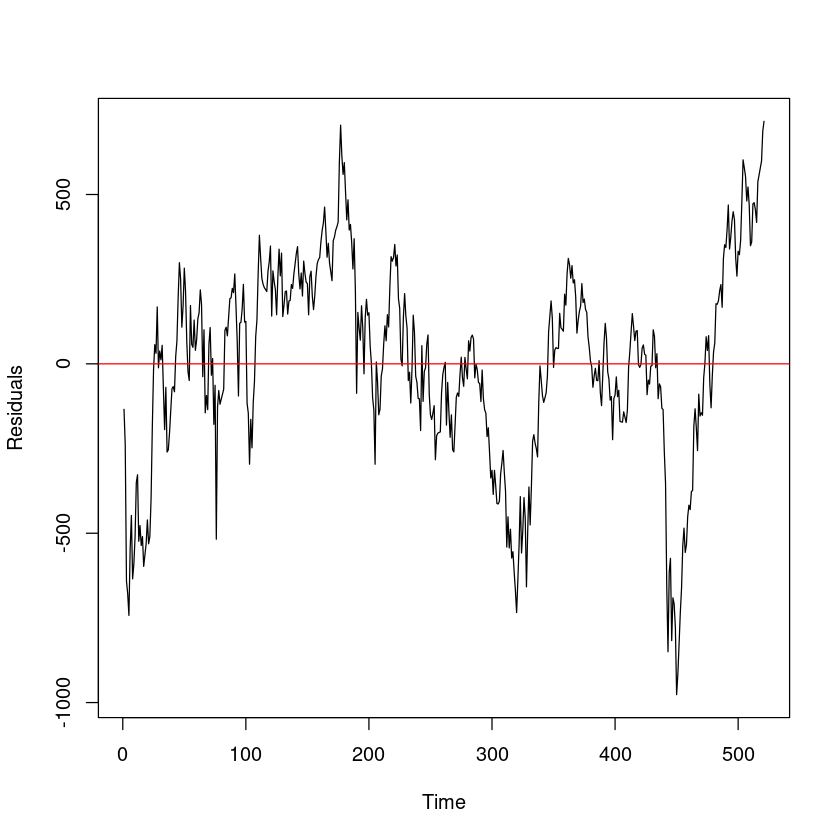

In [14]:
plot(quadratic_model$residuals, type="l", xlab="Time", ylab="Residuals")
abline(0, 0, col="red")
adf.test(quadratic_model$residuals)

La première impression sur l'approximation quadratique semble être confirmée par les résidus. On remarque que ces derniers sont équitablement répartis autour de zéro et que leur valeur absolue maximale est inférieure à 1000.

### Lissage exponentiel

In [15]:
exp_model <- HoltWinters(train_df$Open, 0.95, beta = TRUE, gamma = FALSE, seasonal = "additive")

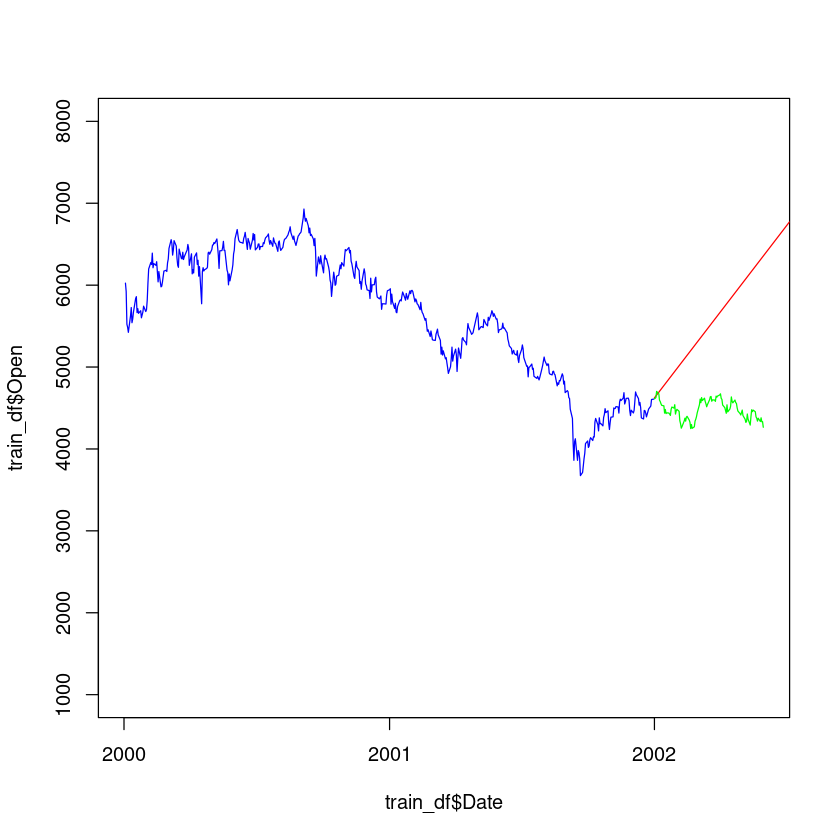

In [16]:
forward_dates <- test_df$Date

plot(
	train_df$Date,
	train_df$Open, 
	type="l",
	col="blue", 
	xlim=c(train_begin, test_end),
	ylim=c(1000, 8000)
)

lines(seq(from=train_end, length.out=200, by="1 day"), predict(exp_model, n.ahead = 200), type="l", col="red")
lines(forward_dates, test_df$Open, col="green", type="l")

Le lissage est ici optimisé pour prévoir les 10 prochains jours, il semble donc ici bien fonctionner pour une période relativement courte, cependant on remarque que la prédiction se révèle totalement fausse pour une période de l'ordre d'un an, ce qui montre bien l'importance d'optimiser le lissage exponentiel à la période voulue

# Prediction

Désormais, on vérifie la pertinence des ces modèles par bloc sur la totalité de la donnée. Pour cela chaque modèle est encapsulé dans une fonction afin d'automatiser les prédiction pour des dates quelconques.

In [17]:
test_linear_model <- function(train_df, test_dates, plot_result = FALSE) {
	# Ajustement d'un modèle linéaire
	linear_model <- lm(Open ~ Date, train_df)

	# Prédiction pour la prochaine période
	model_prediction <- data.frame( Date = test_dates	)
	model_prediction$Open <- predict(linear_model, newdata = model_prediction)
	
	if (plot_result) {
		# Recalcul des prédictions sur toute la période
		date_concat <- c(train_df$Date, test_dates)
		full_pred <- data.frame( Date = date_concat )
		full_pred$Open <- predict(linear_model, newdata = full_pred)
		plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Date", ylab="Indice CAC40")
		lines(full_pred$Date, full_pred$Open, col="red")
		summary(linear_model)

		# Affichage des résiduts autour de 0
		plot(linear_model$residuals, type="l", xlab="Time", ylab="Linear model residuals")
		abline(0, 0, col="red")

		# Test de l'hypothèse de stationnarité
		print(adf.test(linear_model$residuals))
	}

	return(model_prediction)
}

In [21]:
test_quadratic_model <- function(train_df, test_dates, plot_result = FALSE) {
	# Fit a linear model
  t <- as.numeric(train_df$Date)
  tt <- t*t
	linear_model <- lm(Open ~ Date + tt, train_df)

	# Predict the data
	model_prediction <- data.frame( Date = test_dates, tt <- as.numeric(test_dates)^2	)
	model_prediction$Open <- predict(linear_model, newdata = model_prediction)
	
	if (plot_result) {
		# If we decide to plot: fit on the entire dataset
		date_concat <- c(train_df$Date, test_dates)
		full_pred <- data.frame( Date = date_concat, tt <- as.numeric(date_concat)^2 )
		full_pred$Open <- predict(linear_model, newdata = full_pred)
		plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Date", ylab="Indice CAC40")
		lines(full_pred$Date, full_pred$Open, col="red")
		summary(linear_model)

		# Plot residuals around 0
		plot(linear_model$residuals, type="l", xlab="Time", ylab="Linear model residuals")
		abline(0, 0, col="red")

		# Test the hypothesis that the residuals are staionnary
		print(adf.test(linear_model$residuals))
	}

	return(model_prediction)
}

In [18]:
test_exp_smoothing <- function(train_df, test_dates, plot_result = FALSE) {
	exp_model <- HoltWinters(train_df$Open, 0.99, beta = TRUE, gamma = FALSE, seasonal = "additive")

	model_prediction <- data.frame( Date = test_dates )
	model_prediction$Open <- predict(exp_model, n.ahead=length(test_dates))

	if(plot_result) {
		plot(
			train_df$Date,
			train_df$Open, 
			type="l",
			col="blue", 
			xlim=c(train_df$Date[1], test_dates[length(test_dates)]),
			ylim=c(1000, 8000),
			xlab="Temps",
			ylab="Indice CAC40"
		)

		lines(model_prediction$Date, model_prediction$Open, col="red", type="l")
	}

	return(model_prediction)
}

In [19]:
calculate_predictions <- function(model_function, df, begin_date, block_length_days, num_block) {
	result_df <- data.frame()

	for(i in seq(from = 1, to = num_block, by = 1 )) {
		from <- begin_date + block_length_days*i
		to <- begin_date + block_length_days*(i+1)

		test_df <- df[df$Date >= from & df$Date < to,]
		train_df <- df[df$Date >= begin_date & df$Date < from,]
		prediction <- model_function(train_df, test_df$Date, plot_result = FALSE)

		prediction$residuals <- prediction$Open - test_df$Open

		result_df <- rbind(result_df, prediction)
	}

	return(result_df)
}

Grâce à ces fonctions, il est possible de prédire 30 jours à l'avant tous les 30 jours avec les différents modèles

In [20]:
begin <- as.Date("2000-01-01")
num_block <- 10*12
block_length_days <- 30

linear_result <- calculate_predictions(
	test_linear_model,
	df = df,
	begin_date = begin,
	block_length_days = block_length_days,
	num_block = num_block
)

quadratic_result <- calculate_predictions(
	test_quadratic_model,
	df = df,
	begin_date = begin,
	block_length_days = block_length_days,
	num_block = num_block
)

exp_result <- calculate_predictions(
	test_exp_smoothing,
	df = df,
	begin_date = begin,
	block_length_days = block_length_days,
	num_block = num_block
)

exp_result_5days <- calculate_predictions(
	test_exp_smoothing,
	df = df,
	begin_date = begin,
	block_length_days = 5,
	num_block = num_block
)

ERROR: Error in calculate_predictions(test_quadratic_model, df = df, begin_date = begin, : objet 'test_quadratic_model' introuvable


Désormais on peut étudier les résiduts des différents modèles en fonction du temps, sur une longue période.

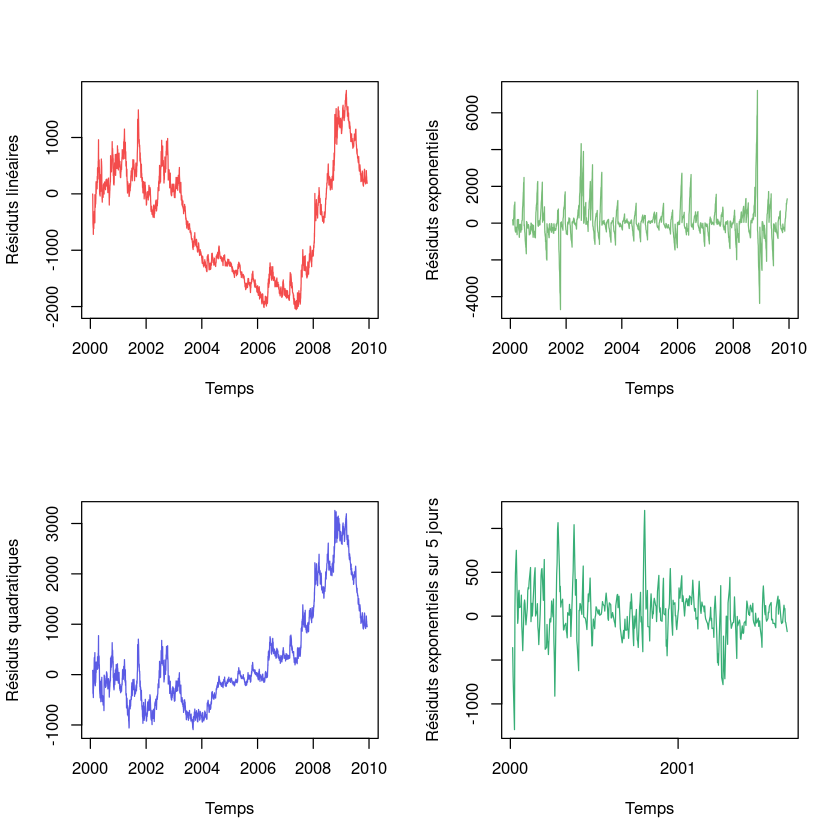

In [ ]:
par(mfrow=c(2,2))
plot(linear_result$Date, linear_result$residuals, type="l", xlab="Temps", ylab="Résiduts linéaires", col="#f34c4c")
plot(exp_result$Date, exp_result$residuals, type="l", col="#79bd79", xlab="Temps", ylab="Résiduts exponentiels")
plot(quadratic_result$Date, quadratic_result$residuals, type="l", col="#5b5be4", xlab="Temps", ylab="Résiduts quadratiques")
plot(exp_result_5days$Date, exp_result_5days$residuals, type="l", col="#37ae76", xlab="Temps", ylab="Résiduts exponentiels sur 5 jours")